In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout,GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D
from keras.applications import MobileNet
from shuffleNet import ShuffleNet

data = []
labels = []
classes = 43
cur_path = os.getcwd()

#Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join(cur_path,'train',str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(path + '\\'+ a)
            image = image.resize((32,32))
            image = np.array(image)
            #sim = Image.fromarray(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

#Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

In [2]:
print(data.shape, labels.shape)
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

(39209, 32, 32, 3) (39209,)
(31367, 32, 32, 3) (7842, 32, 32, 3) (31367,) (7842,)


In [3]:
#Building the model
def cnnModel():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))
    return model

def mobileNet():
    base_model=MobileNet(input_shape=X_train.shape[1:],weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
    x=Dense(1024,activation='relu')(x) #dense layer 2
    x=Dense(512,activation='relu')(x) #dense layer 3
    preds=Dense(43,activation='softmax')(x) #final layer with softmax activation
    model = Model(inputs=base_model.input,outputs=preds)
    return model

def leNet():
    #Instantiate an empty model
    model = Sequential()

    # C1 Convolutional Layer
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=X_train.shape[1:], padding="same"))

    # S2 Pooling Layer
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))

    # C3 Convolutional Layer
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))

    # S4 Pooling Layer
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # C5 Fully Connected Convolutional Layer
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
    #Flatten the CNN output so that we can connect it with fully connected layers
    model.add(Flatten())

    # FC6 Fully Connected Layer
    model.add(Dense(256, activation='relu'))

    #Output Layer with softmax activation
    model.add(Dense(43, activation='softmax'))
    return model

model1 = cnnModel()
model2 = mobileNet()
#model = ShuffleNet(include_top=True, input_shape=X_train.shape[1:],load_model=None, classes=43, pooling='avg')
model3= leNet()

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [4]:
epochs = 15
history1 = model1.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_test, y_test))
history2 = model2.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_test, y_test))
history3 = model3.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_test, y_test))
model1.save("my_model1.h5")
model2.save("my_model2.h5")
model3.save("my_model3.h5")

Epoch 1/15
491/491 [==============================] - 3s 6ms/step - loss: 2.3761 - accuracy: 0.4141 - val_loss: 0.9033 - val_accuracy: 0.7916
Epoch 2/15
491/491 [==============================] - 3s 5ms/step - loss: 0.9656 - accuracy: 0.7170 - val_loss: 0.3996 - val_accuracy: 0.8995
Epoch 3/15
491/491 [==============================] - 3s 5ms/step - loss: 0.6843 - accuracy: 0.7935 - val_loss: 0.2484 - val_accuracy: 0.9374
Epoch 4/15
491/491 [==============================] - 3s 5ms/step - loss: 0.5720 - accuracy: 0.8275 - val_loss: 0.2192 - val_accuracy: 0.9430
Epoch 5/15
491/491 [==============================] - 3s 5ms/step - loss: 0.5050 - accuracy: 0.8496 - val_loss: 0.1695 - val_accuracy: 0.9464
Epoch 6/15
491/491 [==============================] - 3s 5ms/step - loss: 0.4314 - accuracy: 0.8679 - val_loss: 0.1578 - val_accuracy: 0.9515
Epoch 7/15
491/491 [==============================] - 3s 5ms/step - loss: 0.3976 - accuracy: 0.8795 - val_loss: 0.1309 - val_accuracy: 0.9667
Epoch 

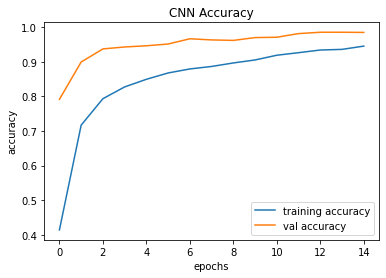

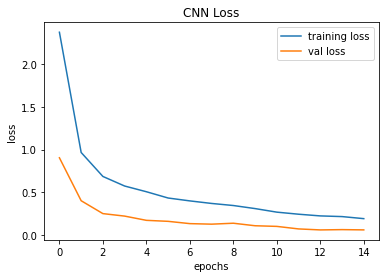

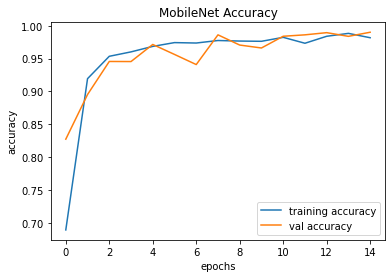

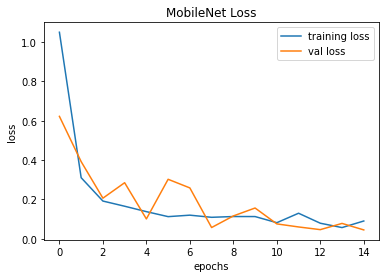

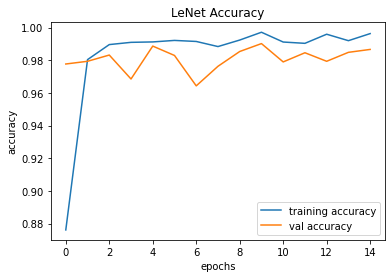

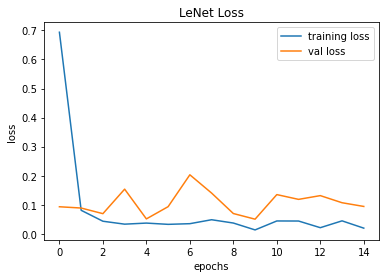

In [5]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history1.history['accuracy'], label='training accuracy')
plt.plot(history1.history['val_accuracy'], label='val accuracy')
plt.title('CNN Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history1.history['loss'], label='training loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.title('CNN Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(history2.history['accuracy'], label='training accuracy')
plt.plot(history2.history['val_accuracy'], label='val accuracy')
plt.title('MobileNet Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(3)
plt.plot(history2.history['loss'], label='training loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.title('MobileNet Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(4)
plt.plot(history3.history['accuracy'], label='training accuracy')
plt.plot(history3.history['val_accuracy'], label='val accuracy')
plt.title('LeNet Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(5)
plt.plot(history3.history['loss'], label='training loss')
plt.plot(history3.history['val_loss'], label='val loss')
plt.title('LeNet Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
#testing accuracy on test dataset
from sklearn.metrics import accuracy_score

y_test = pd.read_csv('Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

data=[]

for img in imgs:
    image = Image.open(img)
    image = image.resize((32,32))
    data.append(np.array(image))

X_test=np.array(data)

pred1 = np.argmax(model1.predict(X_test), axis=-1)
pred2 = np.argmax(model2.predict(X_test), axis=-1)
pred3 = np.argmax(model3.predict(X_test), axis=-1)
#Accuracy with the test data

print("CNN Model: ",accuracy_score(labels, pred1))
print("MobileNet Model: ",accuracy_score(labels, pred2))
print("LeNet Model: ",accuracy_score(labels, pred3))